# ニューラルネットワーク（Neural Network）
## 誤差逆伝播法（Back Propagation）を用いた実装

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path('__file__').resolve().parent.parent.parent.parent))

import numpy as np

from src.modules.scripts.activation_function import softmax
from src.modules.scripts.loss_function import cross_entropy_error
from src.modules.scripts.numeric import numerical_gradient


### データの取得・確認

In [2]:
from keras.datasets import mnist
import pandas as pd

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test = X_test.reshape(10000, 784).astype('float32') / 255
y_train = np.array(pd.get_dummies(y_train))
y_test = np.array(pd.get_dummies(y_test))

print('X_train samples {}'.format(X_train.shape))
print('y_train samples {}'.format(y_train.shape))
print('X_test samples {}'.format(X_test.shape))
print('y_test samples {}'.format(y_test.shape))


Using TensorFlow backend.
/Users/esaki01/.local/share/virtualenvs/ml-notebooks-rAvDjhvL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/esaki01/.local/share/virtualenvs/ml-notebooks-rAvDjhvL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/esaki01/.local/share/virtualenvs/ml-notebooks-rAvDjhvL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(

11493376/11490434 [==============================] - 7s 1us/step
X_train samples (60000, 784)
y_train samples (60000, 10)
X_test samples (10000, 784)
y_test samples (10000, 10)


### レイヤの構築

#### 乗算レイヤの実装

In [3]:
from IPython.display import Image, display_png

display_png(Image('../../static.images/mul_layer.png'))


FileNotFoundError: No such file or directory: '../../static.images/mul_layer.png'

FileNotFoundError: No such file or directory: '../../static.images/mul_layer.png'

In [4]:
class MulLayer(object):
    """乗算レイヤ."""
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        """順伝播.
        
        x, y: 変数
        """
        self.x = x
        self.y = y

        return x * y

    def backward(self, dout):
        """逆伝播.
        
        dout: 順伝播の際の出力変数に対する微分
        """
        # 乗算レイヤはxとyの値をひっくり返す
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy


#### 加算レイヤの実装

In [5]:
from IPython.display import Image, display_png

display_png(Image('../img/add_layer.png'))


FileNotFoundError: No such file or directory: '../img/add_layer.png'

FileNotFoundError: No such file or directory: '../img/add_layer.png'

In [6]:
class AddLayer(object):
    """加算レイヤ."""
    def __init__(self):
        pass

    def forward(self, x, y):
        """順伝播.
        
        x, y: 変数
        """
        return x + y

    def backward(self, dout):
        """逆伝播.
        
        dout: 順伝播の際の出力変数に対する微分
        """
        dx = dout * 1
        dy = dout * 1
        return dx, dy


#### ReLUレイヤの実装

In [7]:
from IPython.display import Image, display_png

display_png(Image('../../static/images/relu_layer.png'))


FileNotFoundError: No such file or directory: '../../static/images/relu_layer.png'

FileNotFoundError: No such file or directory: '../../static/images/relu_layer.png'

In [8]:
class Relu(object):
    """ReLUレイヤ."""
    
    def __init__(self):
        self.mask = None

    def forward(self, x):
        """順伝播.
        
        x: 変数
        """
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out

    def backward(self, dout):
        """逆伝播.
        
        dout: 順伝播の際の出力変数に対する微分
        """
        dout[self.mask] = 0
        dx = dout

        return dx


#### Sigmoidレイヤの実装

In [9]:
from IPython.display import Image, display_png

display_png(Image('../../static/images/sigmoid_layer.png'))


FileNotFoundError: No such file or directory: '../../static/images/sigmoid_layer.png'

FileNotFoundError: No such file or directory: '../../static/images/sigmoid_layer.png'

In [10]:
class Sigmoid(object):
    """Sigmoidレイヤ."""
    
    def __init__(self):
        self.out = None

    def forward(self, x):
        """順伝播.
        
        x: 変数
        """
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        """逆伝播.
        
        dout: 順伝播の際の出力変数に対する微分
        """
        dx = dout * (1.0 - self.out) * self.out

        return dx


#### Affineレイヤの実装

In [11]:
from IPython.display import Image, display_png

display_png(Image('../../static/images/affine_layer.png'))


FileNotFoundError: No such file or directory: '../../static/images/affine_layer.png'

FileNotFoundError: No such file or directory: '../../static/images/affine_layer.png'

In [12]:
class Affine(object):
    """Affineレイヤ.
    
    W: 重み（パラメータ）
    b: バイアス
    """
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        """順伝播.
        
        x: 変数
        """
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        """逆伝播.
        
        dout: 順伝播の際の出力変数に対する微分
        """
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx


#### Softmax-with-lossレイヤの実装

In [13]:
from IPython.display import Image, display_png

display_png(Image('../../static/images/softmax_with_loss_layer.png'))


FileNotFoundError: No such file or directory: '../../static/images/softmax_with_loss_layer.png'

FileNotFoundError: No such file or directory: '../../static/images/softmax_with_loss_layer.png'

In [14]:
class SoftmaxWithLoss(object):
    """Softmax-with-Lossレイヤ."""
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        """順伝播.
        
        x: 変数
        t: 教師データ
        """
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        """逆伝播.
        
        dout: 順伝播の際の出力変数に対する微分
        """
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx


## モデルの構築

In [15]:
# 順序付きのディクショナリ
from collections import OrderedDict


class TwoLayerNet(object):
    """2層ニューラルネットワーク."""
    def __init__(self, input_size, hidden_size, output_size, weight_init=0.01):
        """コンストラクタ.
        
        input_size: 入力層のニューロン数
        hidden_size: 隠れ層のニューロン数
        output_size: 出力層のニューロン数
        weight_init: 重み初期化時のガウス分布のスケール
        """
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

        self._train_loss_list = []
        self._train_acc_list = []
        self._n_iter = 0
        self._epoch = 0

    def fit(self, x, t, iters_num, batch_size, learning_rate):
        """学習する.
        
        x: 入力データ
        t: ターゲット
        iters_num: 訓練回数
        batch_size: バッチサイズ
        learning_rate: 学習率
        """
        # 1エポックあたりの繰り返し数
        iter_per_epoch = max(x.shape[0] / batch_size, 1)

        for i in range(1, iters_num + 1):
            # ミニバッチの取得
            batch_mask = np.random.choice(x.shape[0], batch_size)
            x_batch = x[batch_mask]
            t_batch = t[batch_mask]

            # 勾配の計算
            grad = self.gradient(x_batch, t_batch)

            # パラメータの更新
            for key in ('W1', 'b1', 'W2', 'b2'):
                self.params[key] -= learning_rate * grad[key]

            # 学習過程の記録
            loss = self.loss(x_batch, t_batch)
            self._train_loss_list.append(loss)
            print('\r{}回目のError: {}'.format(i, loss), end='')

            # 1エポックごとに認識精度を計算
            if i % iter_per_epoch == 0:
                train_acc = self.accuracy(x, t)
                self._train_acc_list.append(train_acc)
                print()
                print('{} epoch, train accuracy: {}'.format(int(i / iter_per_epoch), train_acc))
                self._epoch += 1
            self._n_iter += 1

    def predict(self, x):
        """予測値を出力する.
        
        x: 入力データ
        """
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """エラー値を出力する.
        
        x: 入力データ
        t: 教師データ
        """
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        """精度を求める.
        
        x: 入力データ
        t: 教師データ
        """
        y = np.argmax(self.predict(x), axis=1)
        t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def n_gradient(self, x, t):
        """数値微分をする.
        
        x: 入力データ
        t: 教師データ
        """
        loss = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss, self.params['W1'])
        grads['b1'] = numerical_gradient(loss, self.params['b1'])
        grads['W2'] = numerical_gradient(loss, self.params['W2'])
        grads['b2'] = numerical_gradient(loss, self.params['b2'])

        return grads

    def gradient(self, x, t):
        """誤差逆伝播法を用いて微分する.
        
        x: 入力データ
        t: 教師データ
        """
        # 順伝播
        self.loss(x, t)

        # 逆伝播
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads


## 勾配確認（Gradient Checking）

In [16]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

X_batch = X_train[:3]
y_batch = y_train[:3]

grad_numerical = network.n_gradient(X_batch, y_batch)
grad_backprop = network.gradient(X_batch, y_batch)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ': ' + str(diff))


W1: 1.8901012179895135e-07
b1: 3.1158975934374537e-06
W2: 5.409759787544513e-09
b2: 1.3939668896262303e-07


## モデルの訓練・評価

In [17]:
network.fit(X_train, y_train, 6000, 100, 0.1)


600回目のError: 0.21929777221405083
1 epoch, train accuracy: 0.9030166666666667
1200回目のError: 0.28234523735307364
2 epoch, train accuracy: 0.9254333333333333
1800回目のError: 0.13736291660569985
3 epoch, train accuracy: 0.93635
2400回目のError: 0.140252428944398164
4 epoch, train accuracy: 0.9455333333333333
3000回目のError: 0.135628531801696155
5 epoch, train accuracy: 0.9511166666666667
3600回目のError: 0.173932053580642455
6 epoch, train accuracy: 0.95625
4200回目のError: 0.141782849802604585
7 epoch, train accuracy: 0.9603333333333334
4800回目のError: 0.084849236255538785
8 epoch, train accuracy: 0.9623833333333334
5400回目のError: 0.084104613406423584
9 epoch, train accuracy: 0.9672333333333333
6000回目のError: 0.141404972906824575
10 epoch, train accuracy: 0.97075


In [18]:
test_acc = network.accuracy(X_test, y_test)
print('test accuracy:', test_acc)


test accuracy: 0.9637


## 結果の可視化

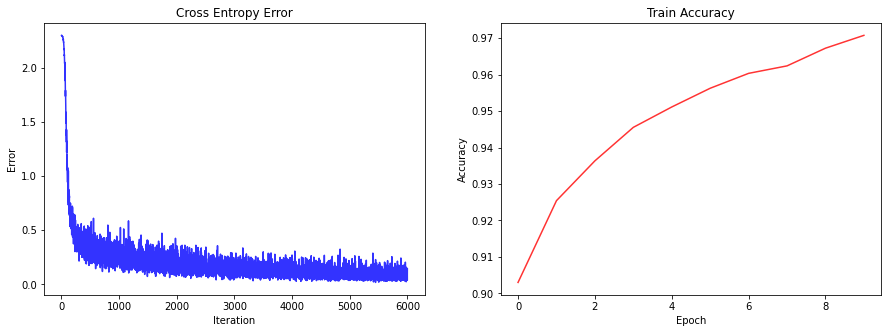

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Cross Entropy Error')
ax.set_ylabel('Error')
ax.set_xlabel('Iteration')
ax.plot(np.arange(network._n_iter), network._train_loss_list, color='b', alpha=0.8)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Train Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.plot(np.arange(network._epoch), network._train_acc_list, color='r', alpha=0.8)

plt.show()
